# 🏎️ Bahrain Day 2 — Data Exploration

Pre-season testing, Day 2. Data captured live from F1TV SignalR feed via the pipeline on `ares-dev-workstation` VM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['font.size'] = 11

# Team colors
TEAM_COLORS = {
    'McLaren':      '#FF8700',
    'Ferrari':      '#E8002D',
    'Red Bull Racing': '#3671C6',
    'Mercedes':     '#27F4D2',
    'Aston Martin': '#229971',
    'Alpine':       '#FF87BC',
    'Williams':     '#64C4FF',
    'RB':           '#6692FF',
    'Kick Sauber':  '#52E252',
    'Haas F1 Team': '#B6BABD',
}

DATA_DIR = '.'  # same directory as notebook

## 1. Load DataFrames

The pipeline produces 3 DataFrames:
- **laps.pkl** — one row per completed lap (timing, sectors, speeds)
- **telemetry.pkl** — high-frequency car data (~3.7 Hz per driver: speed, RPM, throttle, brake, gear)
- **positions.pkl** — GPS positions (~3.7 Hz per driver: X, Y, Z coords on track)

In [2]:
laps = pd.read_pickle(f'{DATA_DIR}/dataframes/laps.pkl')
tele = pd.read_pickle(f'{DATA_DIR}/dataframes/telemetry.pkl')
pos  = pd.read_pickle(f'{DATA_DIR}/dataframes/positions.pkl')

print(f'laps:      {laps.shape[0]:>8,} rows  ×  {laps.shape[1]:>2} cols')
print(f'telemetry: {tele.shape[0]:>8,} rows  ×  {tele.shape[1]:>2} cols')
print(f'positions: {pos.shape[0]:>8,} rows  ×  {pos.shape[1]:>2} cols')

laps:           872 rows  ×  14 cols
telemetry: 2,639,296 rows  ×  10 cols
positions: 2,705,445 rows  ×   7 cols


---
## 2. Laps DataFrame

One row per completed lap per driver. Contains timing and speed-trap data.

In [3]:
laps.head(10)

,DriverNumber,Driver,Team,LapNumber,LapTime,LapEndTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest
0,1,NOR,McLaren,4,35:32.484,2026-02-12T07:51:50.298Z,None,None,27.910,None,None,285,None,False
1,1,NOR,McLaren,5,1:36.187,2026-02-12T07:53:26.453Z,None,None,23.197,None,None,288,None,True
2,1,NOR,McLaren,7,2:19.695,2026-02-12T07:57:54.69Z,None,None,27.968,None,None,279,None,False
3,1,NOR,McLaren,8,1:35.795,2026-02-12T07:59:30.348Z,None,None,23.193,None,None,288,None,True
4,1,NOR,McLaren,9,1:43.541,2026-02-12T08:01:14.051Z,None,None,24.358,None,None,290,None,False
5,1,NOR,McLaren,10,1:38.454,2026-02-12T08:02:53.261Z,None,None,23.893,None,None,305,None,False
6,1,NOR,McLaren,11,1:37.421,2026-02-12T08:04:29.818Z,None,None,23.494,None,None,305,None,False
7,1,NOR,McLaren,12,1:37.290,2026-02-12T08:06:07.199Z,None,None,23.624,None,None,304,None,False
8,1,NOR,McLaren,13,1:37.431,2026-02-12T08:07:44.592Z,None,None,23.690,None,None,303,None,False
9,1,NOR,McLaren,14,1:37.820,2026-02-12T08:09:22.382Z,None,None,23.640,None,None,304,None,False


In [4]:
print('Columns:', list(laps.columns))
print()
laps.info()

Columns: ['DriverNumber', 'Driver', 'Team', 'LapNumber', 'LapTime', 'LapEndTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DriverNumber    872 non-null    object
 1   Driver          872 non-null    object
 2   Team            872 non-null    object
 3   LapNumber       872 non-null    int64 
 4   LapTime         872 non-null    object
 5   LapEndTime      872 non-null    object
 6   Sector1Time     9 non-null      object
 7   Sector2Time     6 non-null      object
 8   Sector3Time     854 non-null    object
 9   SpeedI1         28 non-null     object
 10  SpeedI2         23 non-null     object
 11  SpeedFL         850 non-null    object
 12  SpeedST         28 non-null     object
 13  IsPersonalBest  872 non-null    bool  
d

In [5]:
# Drivers in the session
drivers = laps[['DriverNumber', 'Driver', 'Team']].drop_duplicates().sort_values('DriverNumber')
drivers

,DriverNumber,Driver,Team
0,1,NOR,McLaren
101,10,GAS,Alpine
179,11,PER,Cadillac
215,12,ANT,Mercedes
216,14,ALO,Aston Martin
290,16,LEC,Ferrari
379,18,STR,Aston Martin
380,23,ALB,Williams
431,27,HUL,Audi
463,3,VER,Red Bull Racing


In [6]:
# Parse lap times for analysis
def parse_laptime(t):
    """Convert lap time string (e.g. '1:34.442') to seconds."""
    if pd.isna(t) or t is None:
        return np.nan
    t = str(t)
    if ':' in t:
        parts = t.split(':')
        return int(parts[0]) * 60 + float(parts[1])
    return float(t)

laps['LapTimeSec'] = laps['LapTime'].apply(parse_laptime)

# Lap count per driver
lap_counts = laps.groupby(['Driver', 'Team']).agg(
    TotalLaps=('LapNumber', 'count'),
    FastestLap=('LapTimeSec', 'min')
).reset_index().sort_values('FastestLap')

lap_counts['FastestLapStr'] = lap_counts['FastestLap'].apply(
    lambda s: f"{int(s//60)}:{s%60:06.3f}" if not pd.isna(s) else 'N/A'
)
lap_counts

,Driver,Team,TotalLaps,FastestLap,FastestLapStr
12,LEC,Ferrari,89,94.273,1:34.273
14,NOR,McLaren,101,94.784,1:34.784
3,BEA,Haas F1 Team,90,95.394,1:35.394
18,RUS,Mercedes,27,96.458,1:36.458
8,HAD,Red Bull Racing,63,96.561,1:36.561
4,BOR,Audi,37,96.670,1:36.670
7,GAS,Alpine,78,96.723,1:36.723
5,BOT,Cadillac,48,96.824,1:36.824
0,ALB,Williams,51,97.229,1:37.229
10,HUL,Audi,32,97.266,1:37.266


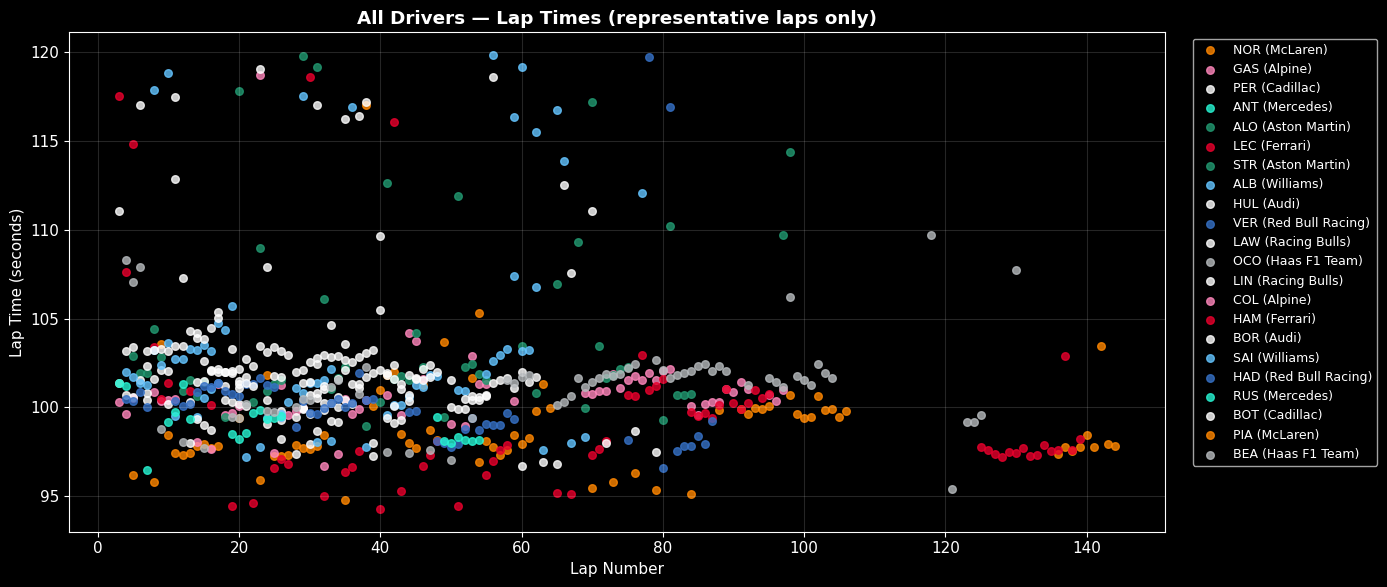

In [7]:
# Only keep representative laps (filter out in/out laps > 2 minutes)
representative = laps[laps['LapTimeSec'] < 120].copy()

fig, ax = plt.subplots(figsize=(14, 6))
for _, row in drivers.iterrows():
    drv = row['Driver']
    team = row['Team']
    drv_laps = representative[representative['Driver'] == drv]
    color = TEAM_COLORS.get(team, '#ffffff')
    ax.scatter(drv_laps['LapNumber'], drv_laps['LapTimeSec'], 
               color=color, s=30, alpha=0.8, label=f"{drv} ({team})")

ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (seconds)')
ax.set_title('All Drivers — Lap Times (representative laps only)', fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.15)
plt.tight_layout()
plt.show()

---
## 3. Telemetry DataFrame

High-frequency car data sampled ~3.7 times per second per driver. This is the core performance data.

In [8]:
tele.head(10)

,Date,DriverNumber,Driver,RPM,Speed,nGear,Throttle,Brake,SessionTime,Distance
0,2026-02-11 16:07:27.335139+00:00,1,NOR,0,0,0,0,0,0.000000,0.0
1,2026-02-11 16:07:27.335139+00:00,1,NOR,0,0,0,0,0,0.000000,0.0
2,2026-02-11 16:07:27.335139+00:00,1,NOR,0,0,0,0,0,0.000000,0.0
3,2026-02-11 16:07:27.656091+00:00,1,NOR,0,0,0,0,0,0.320952,0.0
4,2026-02-11 16:07:27.656091+00:00,1,NOR,0,0,0,0,0,0.320952,0.0
5,2026-02-11 16:07:27.656091+00:00,1,NOR,0,0,0,0,0,0.320952,0.0
6,2026-02-11 16:07:27.816067+00:00,1,NOR,0,0,0,0,0,0.480928,0.0
7,2026-02-11 16:07:27.816067+00:00,1,NOR,0,0,0,0,0,0.480928,0.0
8,2026-02-11 16:07:27.816067+00:00,1,NOR,0,0,0,0,0,0.480928,0.0
9,2026-02-12 06:49:25.298297+00:00,1,NOR,0,0,0,0,0,52917.963158,0.0


In [9]:
print('Columns:', list(tele.columns))
print()
tele.info()

Columns: ['Date', 'DriverNumber', 'Driver', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'SessionTime', 'Distance']

<class 'pandas.core.frame.DataFrame'>
Index: 2639296 entries, 0 to 2639295
Data columns (total 10 columns):
 #   Column        Dtype              
---  ------        -----              
 0   Date          datetime64[ns, UTC]
 1   DriverNumber  object             
 2   Driver        object             
 3   RPM           int64              
 4   Speed         int64              
 5   nGear         int64              
 6   Throttle      int64              
 7   Brake         int64              
 8   SessionTime   float64            
 9   Distance      float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(2)
memory usage: 221.5+ MB


In [10]:
tele.describe()

,RPM,Speed,nGear,Throttle,Brake,SessionTime,Distance
count,2.639296e+06,2.639296e+06,2.639296e+06,2.639296e+06,2.639296e+06,2.639296e+06,2.639296e+06
mean,1.983450e+03,3.270444e+01,1.252289e+00,3.579152e+01,3.015309e+01,6.926299e+04,1.191625e+05
std,3.966090e+03,7.410427e+01,1.169806e+01,4.747472e+01,4.699811e+01,9.469456e+03,1.649277e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.113149e+04,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.919674e+04,1.102102e+04
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,1.000000e+02,7.739472e+04,2.478936e+05
max,1.352300e+04,3.390000e+02,2.550000e+02,1.040000e+02,1.040000e+02,8.592150e+04,7.999883e+05


In [11]:
# Column meanings:
# - Date:          timestamp (UTC) of the sample
# - DriverNumber:  car number (string)
# - Driver:        3-letter code (NOR, LEC, etc.)
# - RPM:           engine RPM
# - Speed:         speed in km/h
# - nGear:         gear number (0 = neutral)
# - Throttle:      throttle position (0-100)
# - Brake:         brake applied (0 or 100)
# - SessionTime:   seconds since session start
# - Distance:      cumulative distance in meters since session start

print('Speed range:', tele['Speed'].min(), '—', tele['Speed'].max(), 'km/h')
print('RPM range:  ', tele['RPM'].min(), '—', tele['RPM'].max())
print('Gears used: ', sorted(tele['nGear'].unique()))
print('Drivers:    ', sorted(tele['Driver'].unique()))

Speed range: 0 — 339 km/h
RPM range:   0 — 13523
Gears used:  [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(54), np.int64(55), np.int64(57), np.int64(59), np.int64(61), np.int64(63), np.int64(64), np.int64(65), np.int64(67), np.int64(68), np.int64(71), np.int64(72), np.int64(73), np.int64(75), np.int64(78), np.int64(81), np.int64(

### Helper: Extract a single lap's telemetry

In [12]:
def get_lap_telemetry(driver: str, lap_number: int):
    """Extract telemetry for a specific driver and lap number.
    
    Returns a DataFrame with Distance reset to 0 at lap start.
    """
    lap_row = laps[(laps['Driver'] == driver) & (laps['LapNumber'] == lap_number)]
    if lap_row.empty:
        raise ValueError(f'Lap {lap_number} not found for {driver}')
    
    lap_row = lap_row.iloc[0]
    lap_end = pd.Timestamp(lap_row['LapEndTime'])
    lap_duration = pd.Timedelta(seconds=parse_laptime(lap_row['LapTime']))
    lap_start = lap_end - lap_duration
    
    drv_tele = tele[tele['Driver'] == driver]
    lap_tele = drv_tele[(drv_tele['Date'] >= lap_start) & (drv_tele['Date'] <= lap_end)].copy()
    lap_tele = lap_tele.sort_values('Date')
    
    if len(lap_tele) > 0:
        lap_tele['LapDistance'] = lap_tele['Distance'] - lap_tele['Distance'].iloc[0]
    
    return lap_tele

# Example: Leclerc's fastest lap
lec_fastest_lap = laps[laps['Driver'] == 'LEC'].copy()
lec_fastest_lap['LapTimeSec'] = lec_fastest_lap['LapTime'].apply(parse_laptime)
lec_fastest_num = int(lec_fastest_lap.loc[lec_fastest_lap['LapTimeSec'].idxmin(), 'LapNumber'])

lap_data = get_lap_telemetry('LEC', lec_fastest_num)
print(f"LEC lap {lec_fastest_num}: {len(lap_data)} telemetry points")
lap_data.head()

LEC lap 40: 359 telemetry points


,Date,DriverNumber,Driver,RPM,Speed,nGear,Throttle,Brake,SessionTime,Distance,LapDistance
634660,2026-02-12 09:28:00.693396+00:00,16,LEC,10632,302,8,100,0,62433.358257,200761.492782,0.000000
634661,2026-02-12 09:28:00.933361+00:00,16,LEC,10777,305,8,100,0,62433.598222,200781.823151,20.330368
634662,2026-02-12 09:28:01.133332+00:00,16,LEC,10876,309,8,100,0,62433.798193,200798.987328,37.494546
634663,2026-02-12 09:28:02.014201+00:00,16,LEC,11236,320,8,100,0,62434.679062,200877.286795,115.794012
634664,2026-02-12 09:28:02.454135+00:00,16,LEC,11344,323,8,100,0,62435.118996,200916.758651,155.265868


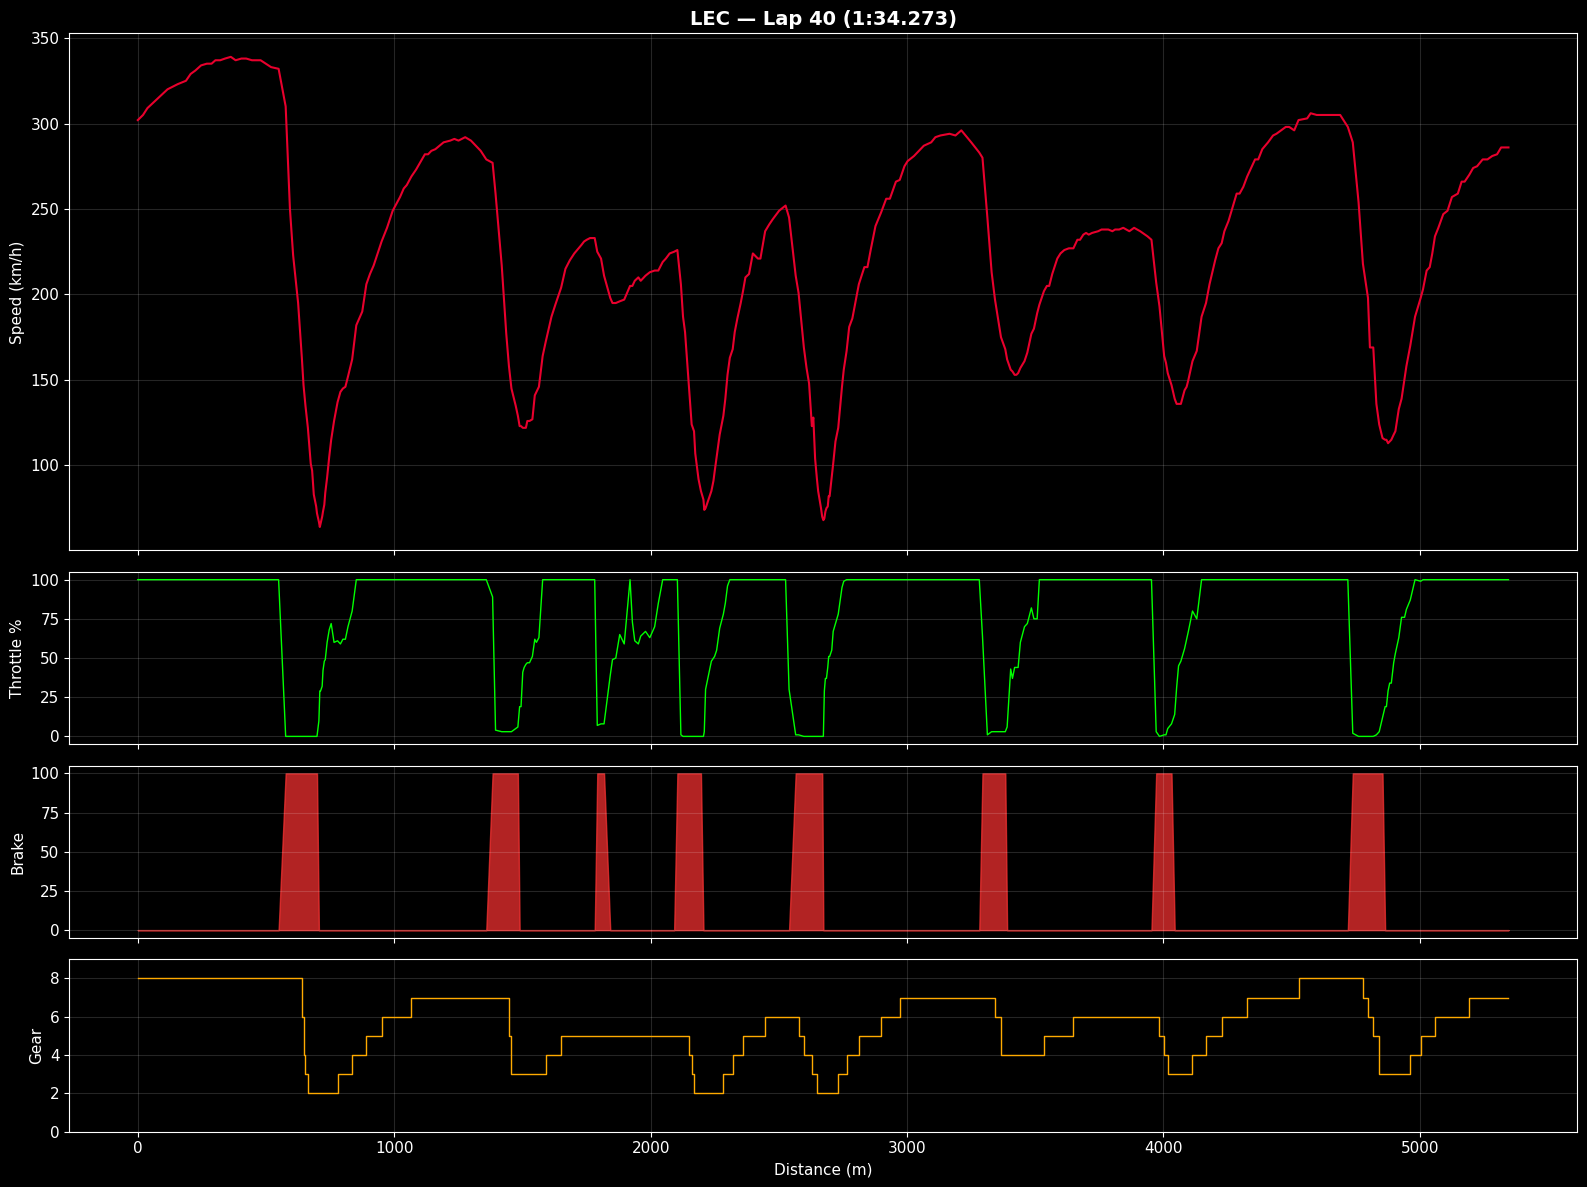

In [13]:
# Full telemetry plot for a single lap
def plot_lap_telemetry(driver, lap_number, color='#E8002D'):
    """Plot speed, throttle, brake, gear, and RPM for a single lap."""
    lap = get_lap_telemetry(driver, lap_number)
    lap_info = laps[(laps['Driver'] == driver) & (laps['LapNumber'] == lap_number)].iloc[0]
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1, 1, 1]})
    
    # Speed
    axes[0].plot(lap['LapDistance'], lap['Speed'], color=color, linewidth=1.5)
    axes[0].set_ylabel('Speed (km/h)')
    axes[0].set_title(f"{driver} — Lap {lap_number} ({lap_info['LapTime']})", 
                       fontweight='bold', fontsize=14)
    
    # Throttle
    axes[1].plot(lap['LapDistance'], lap['Throttle'], color='#00ff00', linewidth=1)
    axes[1].set_ylabel('Throttle %')
    axes[1].set_ylim(-5, 105)
    
    # Brake
    axes[2].fill_between(lap['LapDistance'], 0, lap['Brake'], color='#ff3333', alpha=0.7)
    axes[2].set_ylabel('Brake')
    axes[2].set_ylim(-5, 105)
    
    # Gear
    axes[3].plot(lap['LapDistance'], lap['nGear'], color='#ffaa00', linewidth=1, drawstyle='steps-post')
    axes[3].set_ylabel('Gear')
    axes[3].set_ylim(0, 9)
    axes[3].set_xlabel('Distance (m)')
    
    for ax in axes:
        ax.grid(True, alpha=0.15)
    
    plt.tight_layout()
    plt.show()

plot_lap_telemetry('LEC', lec_fastest_num, color='#E8002D')

---
## 4. Positions DataFrame

GPS-like coordinates sampled at the same rate as telemetry. X/Y/Z are in an F1-internal coordinate system (not lat/lon).

In [14]:
pos.head(10)

,Date,DriverNumber,Driver,X,Y,Z,Status
0,2026-02-11 16:07:45.336566+00:00,1,NOR,-204,1822,-161,OnTrack
1,2026-02-11 16:07:45.336566+00:00,1,NOR,-204,1822,-161,OnTrack
2,2026-02-11 16:07:45.336566+00:00,1,NOR,-204,1822,-161,OnTrack
3,2026-02-11 16:07:45.526537+00:00,1,NOR,-204,1822,-161,OnTrack
4,2026-02-11 16:07:45.526537+00:00,1,NOR,-204,1822,-161,OnTrack
5,2026-02-11 16:07:45.526537+00:00,1,NOR,-204,1822,-161,OnTrack
6,2026-02-12 06:48:52.907610+00:00,1,NOR,0,0,0,OnTrack
7,2026-02-12 06:48:53.007595+00:00,1,NOR,0,0,0,OnTrack
8,2026-02-12 06:48:53.197566+00:00,1,NOR,0,0,0,OnTrack
9,2026-02-12 06:48:53.367540+00:00,1,NOR,0,0,0,OnTrack


In [15]:
print('Columns:', list(pos.columns))
print()
pos.info()

Columns: ['Date', 'DriverNumber', 'Driver', 'X', 'Y', 'Z', 'Status']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705445 entries, 0 to 2705444
Data columns (total 7 columns):
 #   Column        Dtype              
---  ------        -----              
 0   Date          datetime64[ns, UTC]
 1   DriverNumber  object             
 2   Driver        object             
 3   X             int64              
 4   Y             int64              
 5   Z             int64              
 6   Status        object             
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 144.5+ MB


In [16]:
# Column meanings:
# - Date:          timestamp (UTC)
# - DriverNumber:  car number
# - Driver:        3-letter code
# - X, Y, Z:      position coordinates (F1 internal system, unitless)
# - Status:        'OnTrack' or 'OffTrack'

print('X range:', pos['X'].min(), '—', pos['X'].max())
print('Y range:', pos['Y'].min(), '—', pos['Y'].max())
print('Z range:', pos['Z'].min(), '—', pos['Z'].max())
print('Status values:', pos['Status'].value_counts().to_dict())

X range: -5506 — 7518
Y range: -5208 — 8369
Z range: -162 — 5
Status values: {'OnTrack': 2705208, 'OffTrack': 237}


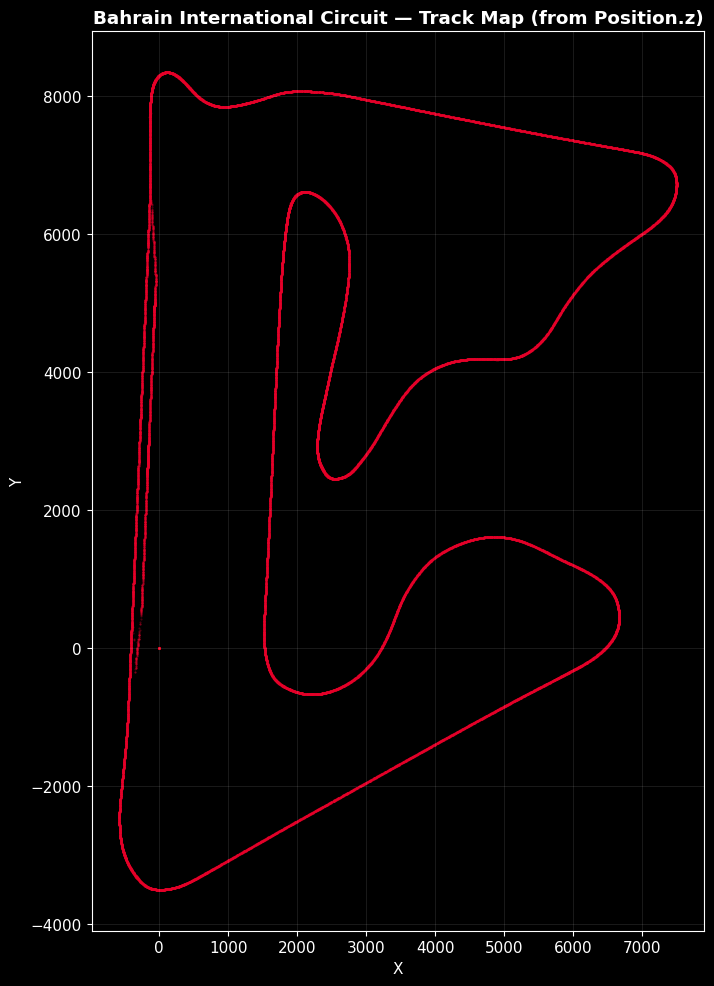

In [17]:
# Plot the track map from position data
# Use one driver's data to draw the circuit
lec_pos = pos[pos['Driver'] == 'LEC'].copy()

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(lec_pos['X'], lec_pos['Y'], c='#E8002D', s=0.3, alpha=0.3)
ax.set_aspect('equal')
ax.set_title('Bahrain International Circuit — Track Map (from Position.z)', fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

---
## 5. Lap Comparison — Speed vs Distance

Compare the fastest laps of two drivers.

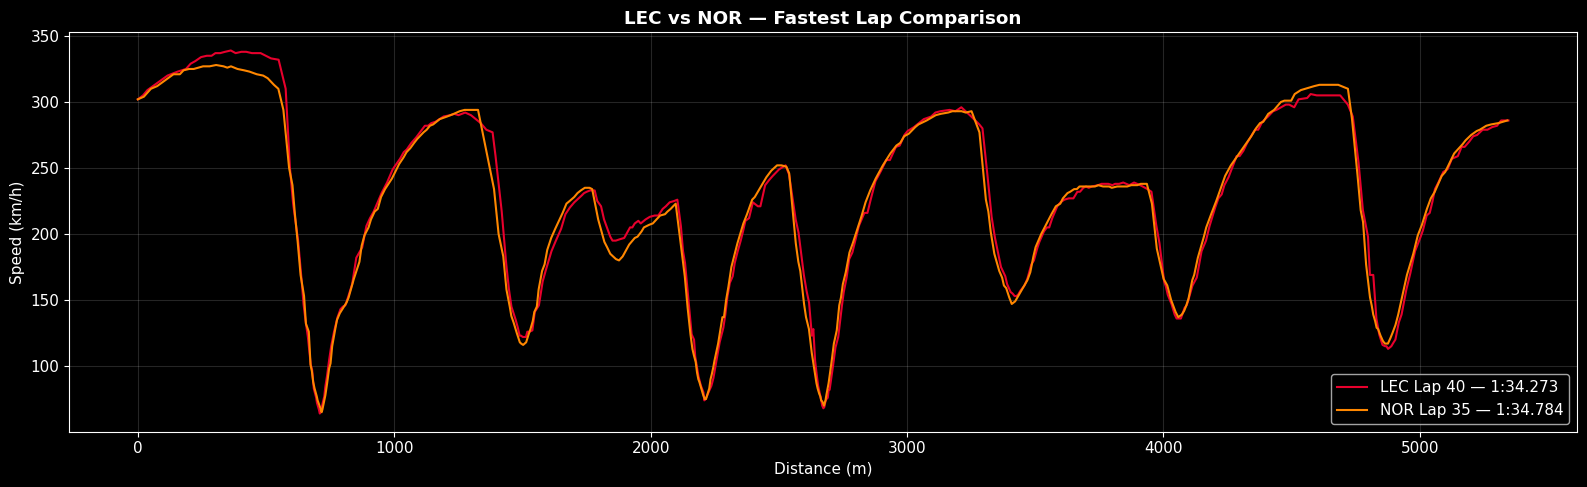

In [18]:
def get_fastest_lap_number(driver):
    """Find the fastest representative lap number for a driver."""
    drv_laps = laps[laps['Driver'] == driver].copy()
    drv_laps['LapTimeSec'] = drv_laps['LapTime'].apply(parse_laptime)
    drv_laps = drv_laps[drv_laps['LapTimeSec'] < 120]  # filter out/in laps
    if drv_laps.empty:
        return None
    return int(drv_laps.loc[drv_laps['LapTimeSec'].idxmin(), 'LapNumber'])

def compare_laps(driver1, driver2):
    """Compare fastest laps of two drivers — speed vs distance."""
    lap1_num = get_fastest_lap_number(driver1)
    lap2_num = get_fastest_lap_number(driver2)
    
    lap1 = get_lap_telemetry(driver1, lap1_num)
    lap2 = get_lap_telemetry(driver2, lap2_num)
    
    team1 = laps[laps['Driver'] == driver1].iloc[0]['Team']
    team2 = laps[laps['Driver'] == driver2].iloc[0]['Team']
    time1 = laps[(laps['Driver'] == driver1) & (laps['LapNumber'] == lap1_num)].iloc[0]['LapTime']
    time2 = laps[(laps['Driver'] == driver2) & (laps['LapNumber'] == lap2_num)].iloc[0]['LapTime']
    
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(lap1['LapDistance'], lap1['Speed'], 
            color=TEAM_COLORS.get(team1, '#fff'), linewidth=1.5,
            label=f'{driver1} Lap {lap1_num} — {time1}')
    ax.plot(lap2['LapDistance'], lap2['Speed'], 
            color=TEAM_COLORS.get(team2, '#aaa'), linewidth=1.5,
            label=f'{driver2} Lap {lap2_num} — {time2}')
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Speed (km/h)')
    ax.set_title(f'{driver1} vs {driver2} — Fastest Lap Comparison', fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.15)
    plt.tight_layout()
    plt.show()

# Example: Leclerc vs Norris
compare_laps('LEC', 'NOR')

---
## 6. Quick Reference

| DataFrame | Key Columns | Use For |
|---|---|---|
| `laps` | Driver, LapNumber, LapTime, Sector1/2/3Time, SpeedI1/I2/FL/ST | Lap analysis, stint analysis, pace trends |
| `telemetry` | Driver, Date, Speed, RPM, nGear, Throttle, Brake, Distance | Speed traces, braking zones, throttle maps |
| `positions` | Driver, Date, X, Y, Z, Status | Track maps, racing lines, overtake analysis |